In [39]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np
from graphgym.custom_graphgym.loader.protein import ProteinDataset

In [61]:
# %connect_info
%qtconsole

Import data from csv fies

In [73]:

# dataset = ProteinDataset("../data/yeast-ORBI", numeric_columns=['protein probability'], label_column=None)
# dataset = ProteinBatchDataset("../data/yeast-LCQ", numeric_params=['protein probability'])
# dataset = ProteinBatchDataset("../data/yeast-ORBI-mRNA", numeric_params=['protein probability', 'mRNA(M)'])
# dataset = ProteinBatchDataset("../data/yeast-LCQ-mRNA", numeric_params=['protein probability', 'mRNA(M)'])
dataset = ProteinDataset("../data/single-soft-label", numeric_columns=['protein_probability'], label_column=None)

In [74]:
dataset.x

tensor([[0.8900],
        [0.7001],
        [0.2869],
        ...,
        [0.0000],
        [0.0000],
        [0.0000]])

(array([ 841.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,   18.,   22.,   33.,   88.,
          66.,   68.,   56.,   61.,   63.,   80.,   66.,   72.,   73.,
          65.,   80.,   86.,   77.,   86.,   80.,   82.,   73.,   84.,
          85.,   99.,   88.,   92.,  116.,  129.,  116.,  111.,  128.,
         112.,  126.,  139.,  104.,  131.,  136.,  119.,  130.,  116.,
         167.,  140.,  124.,  132.,  135.,  138.,  147.,  141.,  136.,
         144.,  156.,  159.,  155.,  153.,  153.,  147.,  176.,  170.,
         160.,  168.,  151.,  168.,  183.,  174.,  214.,  183.,  201.,
         189.,  176.,  183.,  184.,  268.,  218.,  309.,  301.,  238.,
         251.,  248.,  273.,  293.,  322.,  383.,  420.,  453.,  579.,
        6466.]),
 array([0.        , 0.01      , 0.02      , 0.03      , 0.04      ,
        0.05      , 0.06      , 0.07      , 0.08      , 0.09      ,
        0.1       , 0.11      , 0.12      , 0.13      , 0.14      

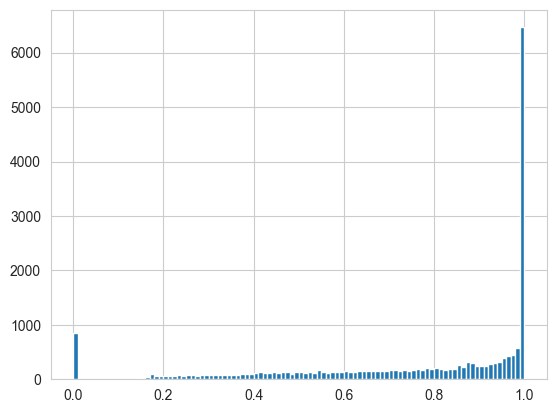

In [75]:
from matplotlib.pyplot import hist

# dataset.y[dataset.train_mask].bincount()
# dataset.y[dataset.val_mask].bincount()
# dataset.y[dataset.test_mask].bincount()
hist(dataset.y, bins=100)

In [76]:
# print(f'Number of nodes: {dataset.num_nodes}')
print(f'Number of node features: {dataset.num_node_features}')
# print(f'Number of edges: {dataset.num_edges}')
print(f'Number of edge features: {dataset.num_edge_features}')
# print(f'Average node degree: {dataset.num_edges / dataset.num_nodes:.2f}')
print(f'Number of training nodes: {dataset.train_mask.sum()}')
# print(f'Training node label rate: {int(dataset.train_mask.sum()) / dataset.num_nodes:.2f}')
# print(f'Validation node label rate: {int(dataset.val_mask.sum()) / dataset.num_nodes:.2f}')
# print(f'Test node label rate: {int(dataset.test_mask.sum()) / dataset.num_nodes:.2f}')
# print(f'Has isolated nodes: {dataset.has_isolated_nodes()}')
# print(f'Has self-loops: {dataset.has_self_loops()}')
# print(f'Is undirected: {dataset.is_undirected()}')

Number of node features: 1
Number of edge features: 0
Number of training nodes: 12256


In [77]:
dataset

ProteinDataset()

In [154]:
from torch.utils.data import DataLoader
import torch
train_dataset = torch.utils.data.TensorDataset(dataset.x[dataset.train_mask], dataset.y[dataset.train_mask])
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = torch.utils.data.TensorDataset(dataset.x[dataset.val_mask], dataset.y[dataset.val_mask])
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = torch.utils.data.TensorDataset(dataset.x[dataset.test_mask], dataset.y[dataset.test_mask])
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [155]:
import os
from torch import optim, nn, utils, Tensor
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import pytorch_lightning as pl
from torchmetrics.classification import BinaryAUROC, BinaryAccuracy, BinaryF1Score


# define the LightningModule
class MLP(pl.LightningModule):
    def __init__(self, num_features, hidden_channels, num_classes, criterion):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = nn.Linear(num_features, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = nn.Linear(hidden_channels, num_classes)
        self.criterion = criterion
        self.val_auroc = BinaryAUROC()
        self.test_auroc = BinaryAUROC()
        # self.val_accuracy = BinaryAccuracy()
        # self.test_accuracy = BinaryAccuracy()
        self.val_F1 = BinaryF1Score()
        self.test_F1 = BinaryF1Score()

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = self.lin2(x)
        x = x.relu()
        x = self.lin3(x)
        return x

    def get_auc(self, out, target):
        return self.auroc(out, target)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)  # Perform a single forward pass.

        loss = self.criterion(logits, y)  # Compute the loss solely based on the training nodes.
        values = {"loss": loss}
        self.log_dict(values, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)  # Perform a single forward pass.

        # self.val_accuracy.update(logits[:, 1], y)
        loss = self.criterion(logits, y)  # Compute the loss solely based on the training nodes.
        self.val_auroc.update(logits, y)
        self.val_F1.update(logits, y)
        values = {"val_loss": loss, "val_auc": self.val_auroc, 'val_F1': self.val_F1}
        self.log_dict(values, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        # self.test_accuracy.update(logits[:, 1], y)
        loss = self.criterion(logits, y)
        self.test_auroc.update(logits, y)
        self.test_F1.update(logits, y)
        values = {"test_loss": loss, "test_auc": self.test_auroc, 'test_F1': self.test_F1}
        self.log_dict(values, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer





In [156]:
# init the autoencoder
MLP_model = MLP(dataset.num_node_features, 10, 2, criterion = torch.nn.CrossEntropyLoss())

In [157]:
trainer = pl.Trainer(limit_train_batches=100, max_epochs=300, enable_progress_bar = False)
trainer.fit(model=MLP_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type             | Params
------------------------------------------------
0 | lin1       | Linear           | 20    
1 | lin2       | Linear           | 110   
2 | lin3       | Linear           | 22    
3 | criterion  | CrossEntropyLoss | 0     
4 | val_auroc  | BinaryAUROC      | 0     
5 | test_auroc | BinaryAUROC      | 0     
6 | val_F1     | BinaryF1Score    | 0     
7 | test_F1    | BinaryF1Score    | 0     
------------------------------------------------
152       Trainable params
0         Non-trainable params
152       Total params
0.001     Total estimated model params size (MB)


RuntimeError: expected scalar type Long but found Float

In [ ]:
trainer.test(model=MLP_model, dataloaders=test_dataloader)

In [27]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

Launching TensorBoard...